# Exploring Toronto Police Services (TPS) Traffic Data

The purpose of this post is to explore and experiment with the TPS Killed or Seriously Injured (KSI) dataset found [here](http://data.torontopolice.on.ca/datasets/ksi). 

## 1. Loading Packages and data

Before doing anything advanced we shall explore some of the elements of the KSI dataset. I've included a version of the dataset downloaded on June 15, 2019. This is done  to ensure replicability. I've also included the metadata file (*KSI_Metadata.xslx*) associated with the dataset.

In [1]:
#Importing all the packages I'll need
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

plt.style.use('fast')

ksi = pd.read_csv('KSI.csv')
ksi.head()

,X,Y,Index_,ACCNUM,YEAR,DATE,TIME,Hour,STREET1,STREET2,...,AG_DRIV,REDLIGHT,ALCOHOL,DISABILITY,Division,Ward_Name,Ward_ID,Hood_ID,Hood_Name,ObjectId
0,-79.454730,43.675280,80771254,7001005616,2017,2017-06-03T04:00:00.000Z,2330,23,ST CLAIR AVE W,CALEDONIA RD,...,Yes,,,,13,NaN,NaN,92,NaN,12001
1,-79.520641,43.770049,80783528,7001744141,2017,2017-09-25T04:00:00.000Z,2330,23,4673 JANE ST,,...,Yes,,,,31,NaN,NaN,24,NaN,12002
2,-79.520641,43.770049,80783529,7001744141,2017,2017-09-25T04:00:00.000Z,2330,23,4673 JANE ST,,...,Yes,,,,31,NaN,NaN,24,NaN,12003
3,-79.286601,43.751868,80790062,7003112978,2017,2017-12-01T05:00:00.000Z,2330,23,BIRCHMOUNT RD,MERRYFIELD DR,...,,,,,41,NaN,NaN,126,NaN,12004
4,-79.286601,43.751868,80790894,7003112978,2017,2017-12-01T05:00:00.000Z,2330,23,BIRCHMOUNT RD,MERRYFIELD DR,...,,,,,41,NaN,NaN,126,NaN,12005


Since some of the column names are uppercase or proper, I shall make the column names consistent by making them all lowercase.

In [2]:
ksi.columns = [x.lower() for x in ksi.columns]

Next, we use see the datatypes of the dataframe.

In [3]:
ksi.dtypes

x                float64
y                float64
index_             int64
accnum             int64
year               int64
date              object
time               int64
hour               int64
street1           object
street2           object
offset            object
road_class        object
district          object
latitude         float64
longitude        float64
loccoord          object
accloc            object
traffctl          object
visibility        object
light             object
rdsfcond          object
acclass           object
impactype         object
invtype           object
invage            object
injury            object
fatal_no           int64
initdir           object
vehtype           object
manoeuver         object
drivact           object
drivcond          object
pedtype           object
pedact            object
pedcond           object
cyclistype        object
cycact            object
cyccond           object
pedestrian        object
cyclist           object


As date is an object, I would prefer if it was `datetime` format. So let's make that change.

In [4]:
ksi['date'] = pd.to_datetime(ksi['date'], format='%Y-%m-%d')

## 2. Exploratory Analysis

Now that some of the data initialization is complete let us do some exploratory work by plotting the number of accidents (`accnum`) per year.

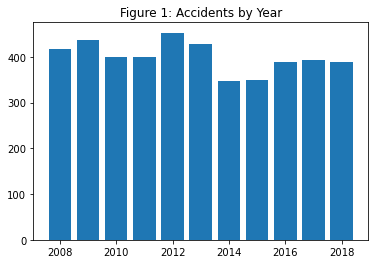

In [5]:
acc_year_uniq = ksi.groupby('year')['accnum'].nunique().reset_index(name='count')
plt.bar(acc_year_uniq['year'],acc_year_uniq['count'])
plt.title('Figure 1: Accidents by Year');

In general we see the number of accidents is relatively consistent around 400, with spikes in 2012 and 2013, followed by a in 2014 and 2015, and accidents returning to ~400 per year. A quick search yields that in 2014 is when the TPS started their *blitz* on distracted driving (see: [here](https://www.cbc.ca/news/canada/distracted-driving-laws-across-canada-1.2576880) and [here](https://www.cbc.ca/news/canada/toronto/distracted-driving-police-blitz-as-province-moves-to-boost-fines-1.2576706)).

However, before looking directly into the impact of the blitz, let's take a slight detour (which also involves a happenin' bus) and really stress the difference between *Figures 1a and 1b*. To skip the detour, click [here](#back_on_route), otherwise... 
![](https://media.giphy.com/media/vhpwk2TOw2hq0/giphy.gif)

### Slight Detour <a id='slight_detour'></a>

Lets take a look at `index_` (unique identifier for an individual in an accent) between 2013-2015 to see if there is a noticable decline after 2014.

In [6]:
accblitz = ksi[ksi['year'].isin([2013,2014,2015])].groupby('date').size().reset_index(name='count')

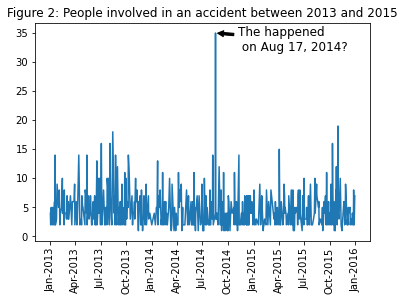

In [7]:
from datetime import datetime, timedelta

fig, ax = plt.subplots()
ax.plot('date','count',data=accblitz)
ax.xaxis.set_major_locator(mdates.MonthLocator([1,4,7,10]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))


# Adding label and arrow
posmax = accblitz.iloc[accblitz['count'].idxmax()]
ax.annotate('The happened \n on {:%b %d, %Y}?'.format(posmax['date']), xy=(posmax['date'], posmax['count']),
           xytext=(posmax['date']+timedelta(days=80), posmax['count']-3), arrowprops=dict(arrowstyle='simple',facecolor='black'), 
            size=12)

plt.title('Figure 2: People involved in an accident between 2013 and 2015')
plt.xticks(rotation=90);

In general it is pretty hard to discern any noticeable patterns, with the exception of August 17<sup>th</sup>, 2014, where 35 people were involved in accidents throughout the day. I imagine that day looking something like below.

![](https://media.giphy.com/media/10mGnyhf8WJa9O/giphy.gif)

So let's take a look at what happened that fateful day by grouping the number of people involved in an accident by hour.

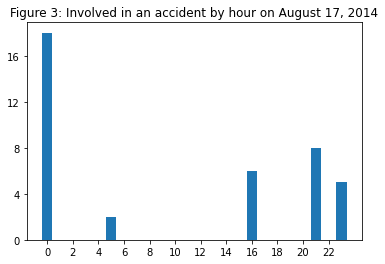

In [8]:
madmax = ksi[(ksi['date']>'2014-08-16') & (ksi['date']<'2014-08-18')].groupby('hour').size().reset_index(name='count')

plt.bar(madmax['hour'],madmax['count'])
plt.xticks(np.arange(0,24,2))
plt.yticks(np.arange(0,20,4))
plt.title('Figure 3: Involved in an accident by hour on August 17, 2014');

From above, we see that at the stroke of midnight all hell broke loose and 18 people were involved in a single accident. Let's dig deeper!

In [9]:
msk = (ksi['hour']==0) & ((ksi['date']>'2014-08-16') & (ksi['date']<'2014-08-18'))

#I'm only interested in a few columns
madmax0 = ksi.loc[msk,['index_','accnum','street1','street2','traffctl','redlight','drivcond','passenger','alcohol','disability',
                       'ag_driv','automobile']]
madmax0

,index_,accnum,street1,street2,traffctl,redlight,drivcond,passenger,alcohol,disability,ag_driv,automobile
1121,80216232,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,Inattentive,Yes,,,Yes,Yes
1122,80216233,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,Normal,Yes,,,Yes,Yes
1123,80216234,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,,Yes,,,Yes,Yes
1124,80216235,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,,Yes,,,Yes,Yes
1125,80216236,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,,Yes,,,Yes,Yes
1126,80216237,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,,Yes,,,Yes,Yes
1127,80216238,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,,Yes,,,Yes,Yes
1128,80216239,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,,Yes,,,Yes,Yes
1129,80216240,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,,Yes,,,Yes,Yes
1130,80216241,4002717713,FINCH AVENUE WEST,ISLINGTON AVENUE,Traffic Signal,Yes,,Yes,,,Yes,Yes


From above we see that all 18 people were involved in a single accident at midnight. As it turns out, the accident was a result of an [inattentive driver of a Jeep getting t-boned by a party bus](https://www.cp24.com/news/man-taken-to-hospital-after-bus-collides-with-jeep-1.1963195). Recreating *Figure 2* for accidents shows August 17<sup>th</sup> was not a good day. 

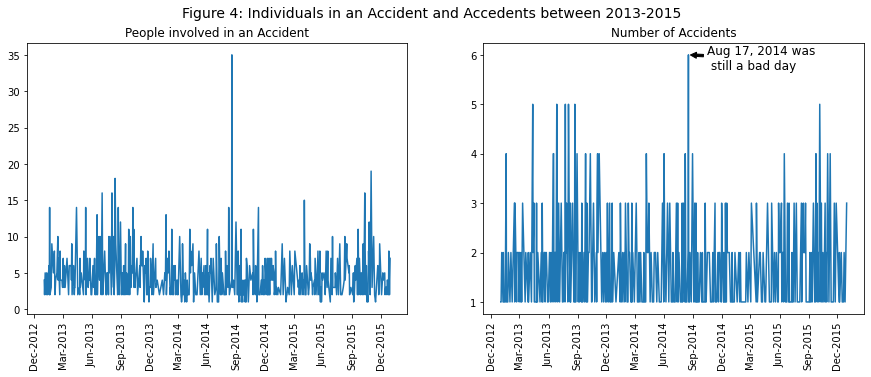

In [10]:
accblitz_uniq = ksi[ksi['year'].isin([2013,2014,2015])].groupby('date')['accnum'].nunique().reset_index(name='count')

fig, ax = plt.subplots(ncols=2,figsize=(15,5))

fig.suptitle("Figure 4: Individuals in an Accident and Accedents between 2013-2015", fontsize = 14)

ax[0].plot('date','count',data=accblitz)
ax[0].xaxis.set_major_locator(mdates.MonthLocator([3,6,9,12]))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax[0].set_title('People involved in an Accident')

ax[1].plot('date','count',data=accblitz_uniq)
ax[1].xaxis.set_major_locator(mdates.MonthLocator([3,6,9,12]))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax[1].set_title('Number of Accidents')

#label
posmax = accblitz_uniq.iloc[accblitz['count'].idxmax()]
ax[1].annotate('{:%b %d, %Y} was \n still a bad day'.format(posmax['date']), xy=(posmax['date'], posmax['count']),
           xytext=(posmax['date']+timedelta(days=60), posmax['count']-0.3), arrowprops=dict(arrowstyle='simple',facecolor='black'),
              size=12)

for axes in fig.axes:
    plt.sca(axes)
    plt.xticks(rotation=90);

### Back on Route <a id='back_on_route'></a>

Let's take a look at the impact of the blitz. Within the dataset there is a `drivcond` variable, which indicates the state of the driver's condition. The possible conditions are the following: 

In [11]:
print(set(ksi['drivcond']))

{'Ability Impaired, Alcohol', 'Inattentive', 'Ability Impaired, Alcohol Over .08', 'Other', 'Medical or Physical Disability', 'Unknown', 'Had Been Drinking', 'Fatigue', 'Ability Impaired, Drugs', 'Normal', ' '}


From the above possibilities (and lack of clear documentation), I shall assume distracted driving from cell phones would fall under *Inattentive*.

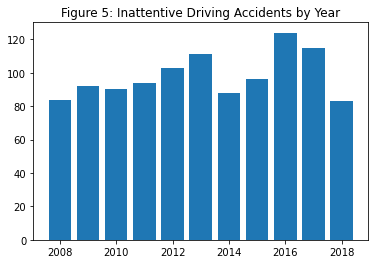

In [12]:
distract = ksi[ksi['drivcond']=='Inattentive'].groupby('year')['accnum'].nunique().reset_index(name='count')

plt.bar(distract['year'],distract['count'])
plt.title('Figure 5: Inattentive Driving Accidents by Year');

So while the blitz was successful in dropping the number of accidents due to inattentive driving in 2014, the number of accidents increased again to new highs in 2016 and 2017. According to this [article](https://www.cbc.ca/news/canada/windsor/opp-distracted-driving-death-1.4019014), 2016 was the worst year for distracted driving fatalities (**Note:** Article cites 65 deaths in *Ontario*, whereas our data is for Toronto). Let's redo *Figure 6* with more detail.

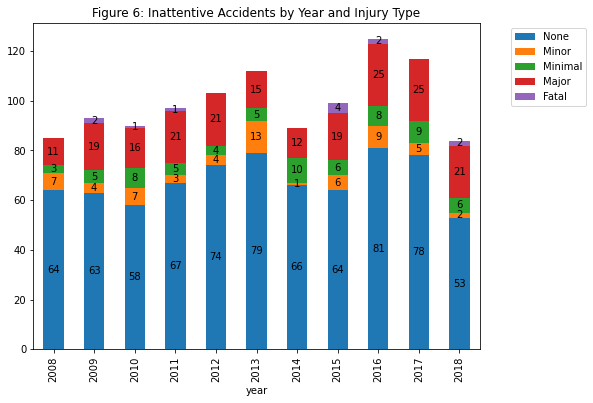

In [13]:
dist_det = ksi[ksi['drivcond']=='Inattentive'].groupby(['year','injury'])['accnum'].nunique().reset_index(
    name='count').pivot(columns='injury', index='year', values='count')

#Re-order columns so plotting the stacked columns are in an order I want
neworder = ['None','Minor','Minimal','Major','Fatal']
dist_det = dist_det.reindex(columns=neworder)

# plot the data

ax = dist_det.plot(kind='bar', stacked=True, figsize=(8,6), title='Figure 6: Inattentive Accidents by Year and Injury Type')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2, y+height/2, np.where(height==0,'','{:.0f}'.format(height)), ha='center', va='center');
ax.legend(loc='upper right', bbox_to_anchor=(1.25,1));

The above provides an interesting perspective on the article. Although there were more fatalities and major injuries from inattentive drivers in 2016, majority of the accidents did not result in injuries, with only 2 fatalities in Toronto. This leads us to believe that most of the fatalities cited &mdash;65 total in Ontario&mdash; in the article were outside of Toronto.

In a similar manner as above, we can take a look at a number of different variables.

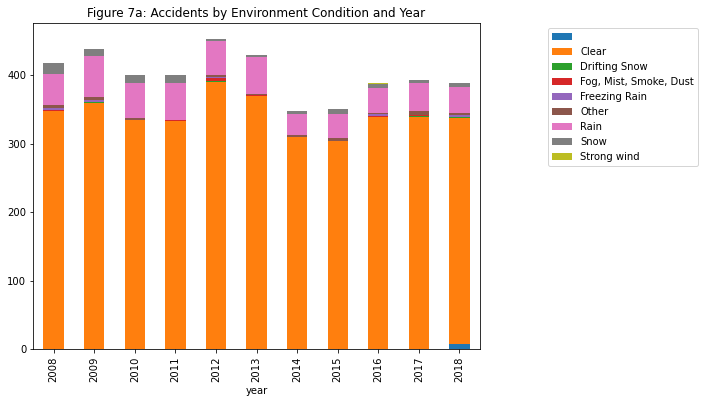

In [14]:
acc_vis = ksi.groupby(['year','visibility'])['accnum'].nunique().reset_index(
    name='count').pivot(columns='visibility', index='year', values='count')

# plot the data

ax = acc_vis.plot(kind='bar', stacked=True, figsize=(8,6), title='Figure 7a: Accidents by Environment Condition and Year')
ax.legend(loc='upper right', bbox_to_anchor=(1.5,1));

Since there seem to be blanks under `visibility`, I shall assume the visibility condition was clear.

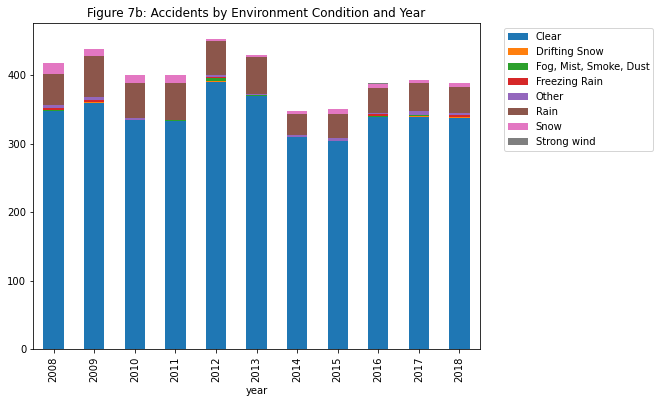

In [15]:
ksi['visibility'].replace(' ','Clear', inplace = True )

# Re-plotting the data 
acc_vis = ksi.groupby(['year','visibility'])['accnum'].nunique().reset_index(
    name='count').pivot(columns='visibility', index='year', values='count')

# plot the data

ax = acc_vis.plot(kind='bar', stacked=True, figsize=(8,6), title='Figure 7b: Accidents by Environment Condition and Year')
ax.legend(loc='upper right', bbox_to_anchor=(1.4,1));

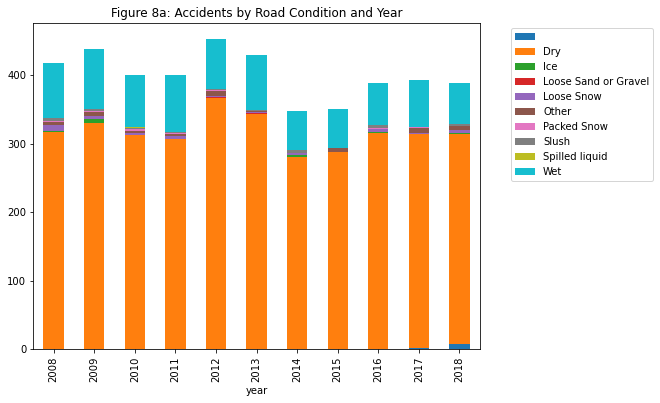

In [16]:
acc_cond = ksi.groupby(['year','rdsfcond'])['accnum'].nunique().reset_index(
    name='count').pivot(columns='rdsfcond', index='year', values='count')

# plot the data

ax = acc_cond.plot(kind='bar', stacked=True, figsize=(8,6), title='Figure 8a: Accidents by Road Condition and Year')
ax.legend(loc='upper right', bbox_to_anchor=(1.4,1));

Here, we shall tread blanks as *Dry* condition.

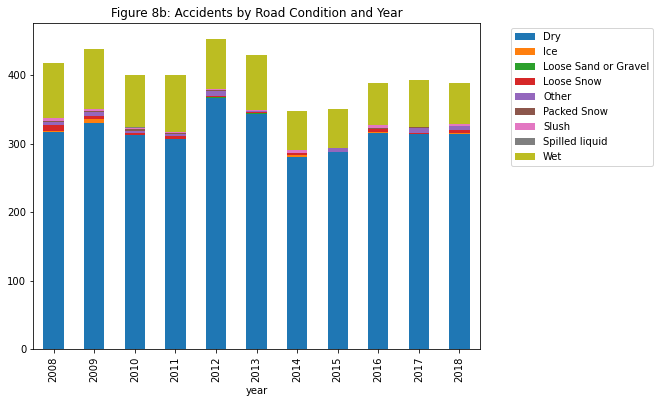

In [17]:
ksi['rdsfcond'].replace(' ','Dry', inplace = True)

acc_cond = ksi.groupby(['year','rdsfcond'])['accnum'].nunique().reset_index(
    name='count').pivot(columns='rdsfcond', index='year', values='count')

# ploting the Figure

ax = acc_cond.plot(kind='bar', stacked=True, figsize=(8,6), title='Figure 8b: Accidents by Road Condition and Year')
ax.legend(loc='upper right', bbox_to_anchor=(1.4,1));


Counterintuitively, majority of the accidents happen when weather is clear and the roads are dry. Possible reasons is that individuals may drive more aggressively in clearer conditions. The `driveact` variable gives the actions of the driver that led to the accident. Since we are only concerned with the driver's actions, we shall drop passengers (as well as blanks for `driveact`.

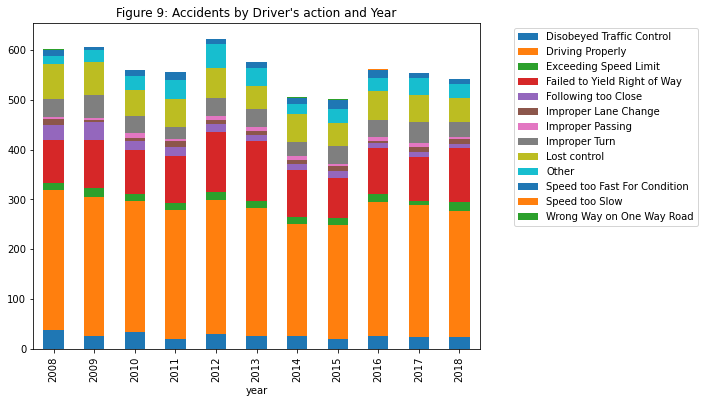

In [18]:
msk = (ksi['drivact'] == ' ') | (ksi['invtype']=='Passenger')
acc_dract = ksi[~msk].groupby(['year','drivact']).size().reset_index(
    name='count').pivot(columns='drivact', index='year', values='count')

# plot the data

ax = acc_dract.plot(kind='bar', stacked=True, figsize=(8,6), title='Figure 9: Accidents by Driver\'s action and Year')
ax.legend(loc='upper right', bbox_to_anchor=(1.5,1));

The above chart shows that majority of the drivers were driving properly when they were involved in an accident, which does not make sense. However, in the above chart we do not account for who was at fault or responsible for the accident. Since there doesn't seem to a variable for "at fault", we shall assume drivers that were driving properly were not at fault and drop them from the plot. 

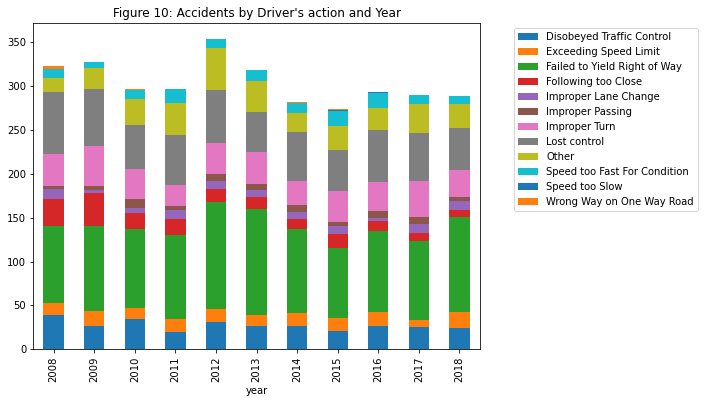

In [19]:
msk = (ksi['drivact'] == ' ') | (ksi['invtype']=='Passenger') | (ksi['drivact'] == 'Driving Properly') 
acc_dract = ksi[~msk].groupby(['year','drivact']).size().reset_index(
    name='count').pivot(columns='drivact', index='year', values='count')

# plot the data

ax = acc_dract.plot(kind='bar', stacked=True, figsize=(8,6), title='Figure 10: Accidents by Driver\'s action and Year')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()    
ax.legend(loc='upper right', bbox_to_anchor=(1.5,1));

Considering only *at fault* accidents, failing to yield right of way is the main action that causes accidents. Now we can continue on in a similar manner for days, but we shall leave it here.